---
# Import Libraries
---

In [1]:
import numpy as np 
import pandas 
import csv
import warnings
import nltk
import os
import string
import time
import pickle
import seaborn as sns
import csv
from pathlib import Path
import matplotlib.pyplot as plt
nltk.download('names')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import names
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")
src='/home/shared_data/textmining_genderrecognition_topicextraction/dataset_text_mining_Reuters_RCV2/'
label_59=False

[nltk_data] Downloading package names to
[nltk_data]     /home/mattia_gatto/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mattia_gatto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mattia_gatto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/mattia_gatto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mattia_gatto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


---
# Data Upload
---

In [2]:
path_file=src+"clean_dataset_with_label.csv"
df=pandas.read_csv(path_file)
len(df)
df.head()

,title,headline,autore,code,text,Genere,industry_codes,region_codes,topic_codes
0,"UK: UK shares set for nervous week,upside seen...","UK shares set for nervous week,upside seen lim...",Dale Faulken,"UK,M11,MCAT",The UK share market is unlikely to make much h...,Neutral,NaN,UK,"M11,MCAT"
1,USA: CBOT wheat ends mostly lower on weather.,CBOT wheat ends mostly lower on weather.,NaN,"USA,M14,M141,MCAT",CBOT soft red winter wheat futures closed most...,Unknown,NaN,USA,"M14,M141,MCAT"
2,CHINA: Beijing slams U.S. sanctions against Ch...,Beijing slams U.S. sanctions against China firms.,Mure Dickie,"CHINA,IRAN,USA,E51,E512,ECAT,GCAT,GDIP",Beijing on Friday condemned U.S. sanctions imp...,Unknown,NaN,"CHINA,IRAN,USA","E51,E512,ECAT,GCAT,GDIP"
3,JAPAN: Sakura Bank -97/98 parent forecast.,Sakura Bank -97/98 parent forecast.,NaN,"JAP,I81402,C15,C152,CCAT","Year to March 31, 1998 \t\t (in billions of ...",Unknown,I81402,JAP,"C15,C152,CCAT"
4,UK: Pregnant IRA bomb suspect released on bail.,Pregnant IRA bomb suspect released on bail.,NaN,"GFR,UK,GCAT,GCRIM,GPOL,GVIO",A pregnant IRA bomb suspect was released on ba...,Unknown,NaN,"GFR,UK","GCAT,GCRIM,GPOL,GVIO"


---
# DROP missing values
---

In [3]:
final_df=df.copy()
print(len(final_df))
final_df.isna().sum()

803066


title                  1
headline               8
autore            694432
code                   0
text                   0
Genere                 0
industry_codes    451945
region_codes          12
topic_codes         2263
dtype: int64

In [4]:
df_T=final_df.copy()
topic_not_na=df_T.dropna( subset=['topic_codes']).reset_index(drop=True)
print('prima--->',len(final_df),',dopo--->',len(topic_not_na),'(eliminati',len(final_df)-len(topic_not_na),'topic_codes null)')

prima---> 803066 ,dopo---> 800803 (eliminati 2263 topic_codes null)


In [5]:
clear_ds=topic_not_na.drop(['industry_codes','region_codes'], axis = 1) 
clear_ds.isna().sum()

title               0
headline            5
autore         692685
code                0
text                0
Genere              0
topic_codes         0
dtype: int64

In [6]:
clear_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800803 entries, 0 to 800802
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        800803 non-null  object
 1   headline     800798 non-null  object
 2   autore       108118 non-null  object
 3   code         800803 non-null  object
 4   text         800803 non-null  object
 5   Genere       800803 non-null  object
 6   topic_codes  800803 non-null  object
dtypes: object(7)
memory usage: 42.8+ MB


---
# Create label target
---

## Combine the labels

In [7]:
def controlla_cod(cod,dict_from_csv,lista_cod,lista_eliminati,lista_eliminati_descr,end_list):
    update=0
    for next_code in range (cod+1,end_list):
        if lista_cod[cod][:3]==lista_cod[next_code][:3] and lista_cod[cod][1].isdigit():
            print('Aggrego',lista_cod[next_code],'nella radice:',lista_cod[cod])
            lista_eliminati_descr[lista_cod[next_code]]= dict_from_csv[lista_cod[next_code]]
            lista_eliminati[lista_cod[next_code]]= lista_cod[cod]
            del dict_from_csv[lista_cod[next_code]]
            update+=1
    return update


def aggrega_etichette(topic_file='topic_codes.csv'):
    mydict = {}
    with open(src+'topic_codes.csv', mode='r') as inp:
        reader = csv.reader(inp)
        dict_from_csv = {rows[0]:rows[1] for rows in reader}
    del dict_from_csv['topic_code']
    end_list=len(dict_from_csv)
    lista_cod=(list(dict_from_csv.keys()))
    salta=0
    lista_eliminati_descr={}
    lista_eliminati={}
    topics_aggregated_key={}
    for cod in range(end_list):
        if salta==0:
            radice=lista_cod[cod][:3]
            salta=controlla_cod(cod,dict_from_csv,lista_cod,lista_eliminati,lista_eliminati_descr,end_list)
            topics_aggregated_key[lista_cod[cod]]= dict_from_csv[lista_cod[cod]]
        else:
            salta-=1
    return topics_aggregated_key,lista_eliminati,lista_eliminati_descr

In [8]:
topics_aggregated_key,lista_eliminati,lista_eliminati_descr=aggrega_etichette()
print('label attuali:', len(topics_aggregated_key),',accorpate:',len(lista_eliminati),'su',len(topics_aggregated_key)+len(lista_eliminati),'totali')

Aggrego C151 nella radice: C15
Aggrego C1511 nella radice: C15
Aggrego C152 nella radice: C15
Aggrego C171 nella radice: C17
Aggrego C172 nella radice: C17
Aggrego C173 nella radice: C17
Aggrego C174 nella radice: C17
Aggrego C181 nella radice: C18
Aggrego C182 nella radice: C18
Aggrego C183 nella radice: C18
Aggrego C311 nella radice: C31
Aggrego C312 nella radice: C31
Aggrego C313 nella radice: C31
Aggrego C331 nella radice: C33
Aggrego C411 nella radice: C41
Aggrego E121 nella radice: E12
Aggrego E131 nella radice: E13
Aggrego E132 nella radice: E13
Aggrego E141 nella radice: E14
Aggrego E142 nella radice: E14
Aggrego E143 nella radice: E14
Aggrego E211 nella radice: E21
Aggrego E212 nella radice: E21
Aggrego E311 nella radice: E31
Aggrego E312 nella radice: E31
Aggrego E313 nella radice: E31
Aggrego E411 nella radice: E41
Aggrego E511 nella radice: E51
Aggrego E512 nella radice: E51
Aggrego E513 nella radice: E51
Aggrego G111 nella radice: G11
Aggrego G112 nella radice: G11
Aggrego

---
## Replace the roots merged with the special cases of the labels in the dataset
---

In [9]:
def aggrega_codes(df,lista_eliminati):
    cod=df['topic_codes']
    topic_codes=pandas.read_csv(src+'topic_codes.csv')
    topic_codes_list=topic_codes['topic_code'].values
    df_code_topic=[]
    i=0
    check=200000
    start = time.time()
    for code_record in cod.values:
        codici=code_record.split(',')
        single_topic=[]
        for c in codici:
            if c in (list(lista_eliminati.keys())):
                single_topic.append(lista_eliminati[c])
            else:
                single_topic.append(c)
        df_code_topic.append(str(",".join(set(single_topic)))) 
        if(i%check==0 and i!=0):
            print('elaborati',i,'record!')
        i+=1

    end = time.time()
    t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end)-int(start)))
    print("tempo impiegato per accorpare le etichette nella colonna topics_codes è di: "+t)
    df['topic_codes']=df_code_topic
    return df
clear_ds=aggrega_codes(clear_ds,lista_eliminati)
clear_ds.head(2)

elaborati 200000 record!
elaborati 400000 record!
elaborati 600000 record!
elaborati 800000 record!
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:08s


,title,headline,autore,code,text,Genere,topic_codes
0,"UK: UK shares set for nervous week,upside seen...","UK shares set for nervous week,upside seen lim...",Dale Faulken,"UK,M11,MCAT",The UK share market is unlikely to make much h...,Neutral,"M11,MCAT"
1,USA: CBOT wheat ends mostly lower on weather.,CBOT wheat ends mostly lower on weather.,NaN,"USA,M14,M141,MCAT",CBOT soft red winter wheat futures closed most...,Unknown,"M14,MCAT"


---
## Delete the labels not contained in the dataset
---

In [38]:
def plot_topic_occ(codes, codes_names,size=(25, 50)):
    plt.figure(figsize=(25,25))
    y_ticks = np.arange(0, len(codes))
    fig, ax = plt.subplots(figsize = size)
    ax.barh(y_ticks, codes , color='seagreen')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(codes_names)
    plt.ylabel("label")
    plt.xlabel("size")
    plt.show()
    
def plotta_label_pie_from_dict(occorrenze,size=(20,20),valori_plottati=2,title_chart='tipologia',fz=40):
    #ordina dizionario
    lb=list(occorrenze.keys())  
    diz={}
    occ=list(occorrenze.values())
    for i in range (len(occorrenze)):
        diz[lb[i]]=occ[i]
    sorted_dict = {}
    sorted_dict = sorted(diz.items(), key = lambda kv: kv[1])
    
    stampa={}
    num_stampe=valori_plottati
    for i in range (len(occorrenze)-num_stampe,len(occorrenze)):
        stampa[sorted_dict[i][0]]=int(sorted_dict[i][1])

    
    if(len(occorrenze)-num_stampe)>0:
        stampa['altro']=0        
        for i in range (len(occorrenze)-num_stampe):
            stampa['altro']+=int(sorted_dict[i][1])
    #stampa=occorrenze
    t=len(stampa)
    cs = []
    n = t
    for i in range(n):
        cs.append('#%06X' % randint(0, 0xFFFFFF))
    labels = list(stampa.keys())
    sizes = list(stampa.values())
    explode = np.zeros(t) 
    explode[t-2]=0.1
    fig1, ax1 = plt.subplots(figsize=size)
    ax1.pie(sizes, explode=explode,  autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 40},colors=cs)
    ax1.axis('equal')  
    ax1.legend(labels, prop={'size': 30})
    plt.title(title_chart, fontsize=fz)
    plt.show()
    
def vector_sum(y_topic_dict,y_label_code):
    somma=np.zeros(len(y_topic_dict),dtype=int)
    for vect in y_label_code:
        somma=somma+vect
    return somma

def count_occ(somma,codes_names):
    occorrenze={}
    i=0
    for n in codes_names:
        occorrenze[n]=somma[i]
        i+=1
    #valori con occ >0
    i=0
    for k in occorrenze.keys():
        if (int(occorrenze[k])!=0.0):
            i+=1
    print("valori con occ>0:",i)
    return occorrenze


def Y_label_codes(dataset,name_code):
    y_topic_dict={}
    for nam in name_code:
        y_topic_dict[nam]=0
    codes=list(dataset['topic_codes'].values)
    y_label_code=[]
    occ=0
    occ_print=200000
    for record_codes in codes:
        if str(record_codes)!='nan':
            record_codes_list=record_codes.split(',')
            label=y_topic_dict.copy()
            for cod in record_codes_list:
                label[cod]+=1
            y_label_code.append(list(label.values()))
        else:
            y_label_code.append(list(0 for i in range(0, len(label))))
        if (occ%occ_print==0 and occ!=0) or (occ==(len(codes)-1)):
            print('analizzati',occ,'record')
        occ+=1
    return y_label_code,y_topic_dict

def drop_label_non_presenti(y_topic_dict):
    ris=y_topic_dict.copy()
    i=0
    for k in list(ris.keys()):
        ris[k]=somma[i]
        i+=1
    occ_drop=0
    prec=len(ris)
    for k in list(ris.keys()):
        if ris[k]==0:
            del ris[k]
            occ_drop+=1
    print('prima-->',prec,',dopo-->',len(ris),',eliminate',occ_drop,'label con occorrenza = 0')
    return ris,ris.keys()

In [11]:
y_label_code,y_topic_dict=Y_label_codes(clear_ds,topics_aggregated_key.keys())

analizzati 200000 record
analizzati 400000 record
analizzati 600000 record
analizzati 800000 record
analizzati 800802 record


valori con occ>0: 59


<Figure size 1800x1800 with 0 Axes>

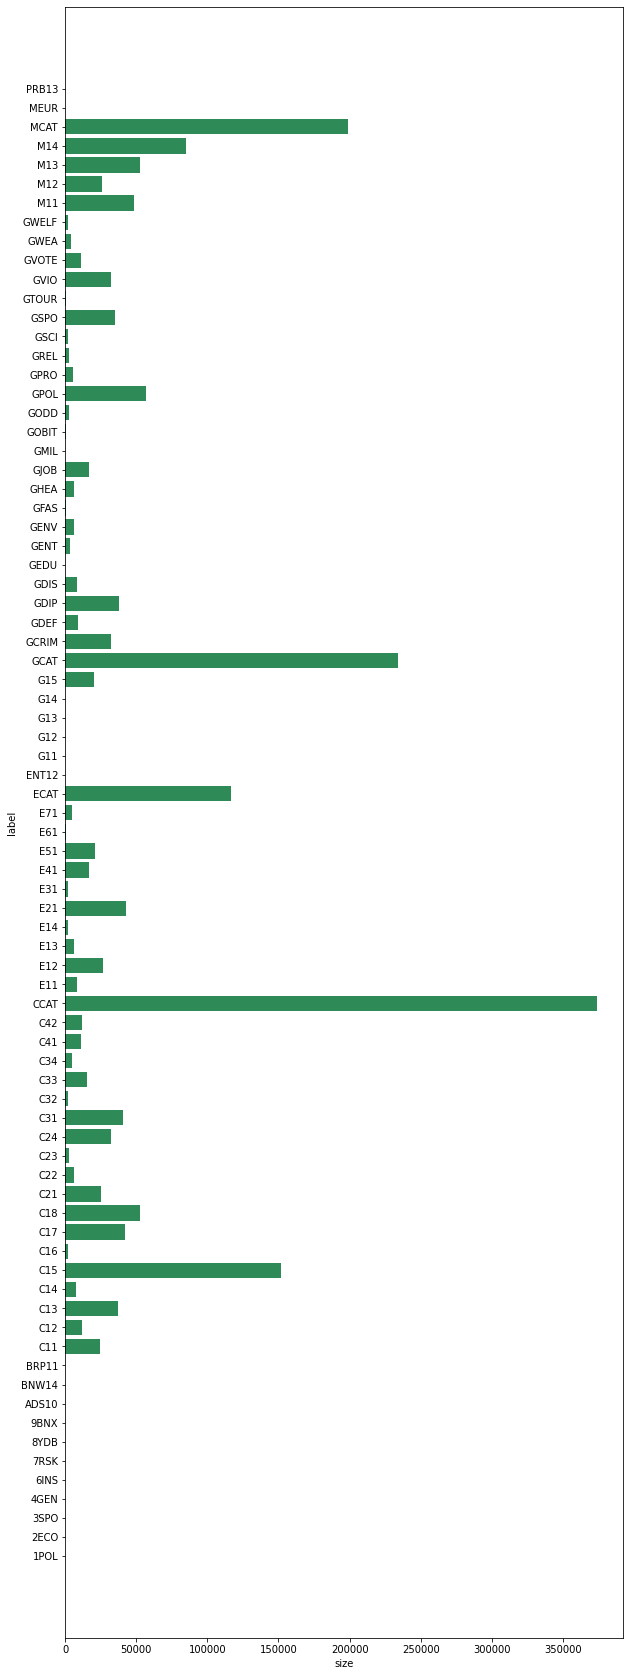

In [12]:
somma=vector_sum(y_topic_dict,y_label_code)
codes_names=y_topic_dict.keys()
occorrenze=count_occ(somma,codes_names)
plot_topic_occ(somma, codes_names,size=(10,30))

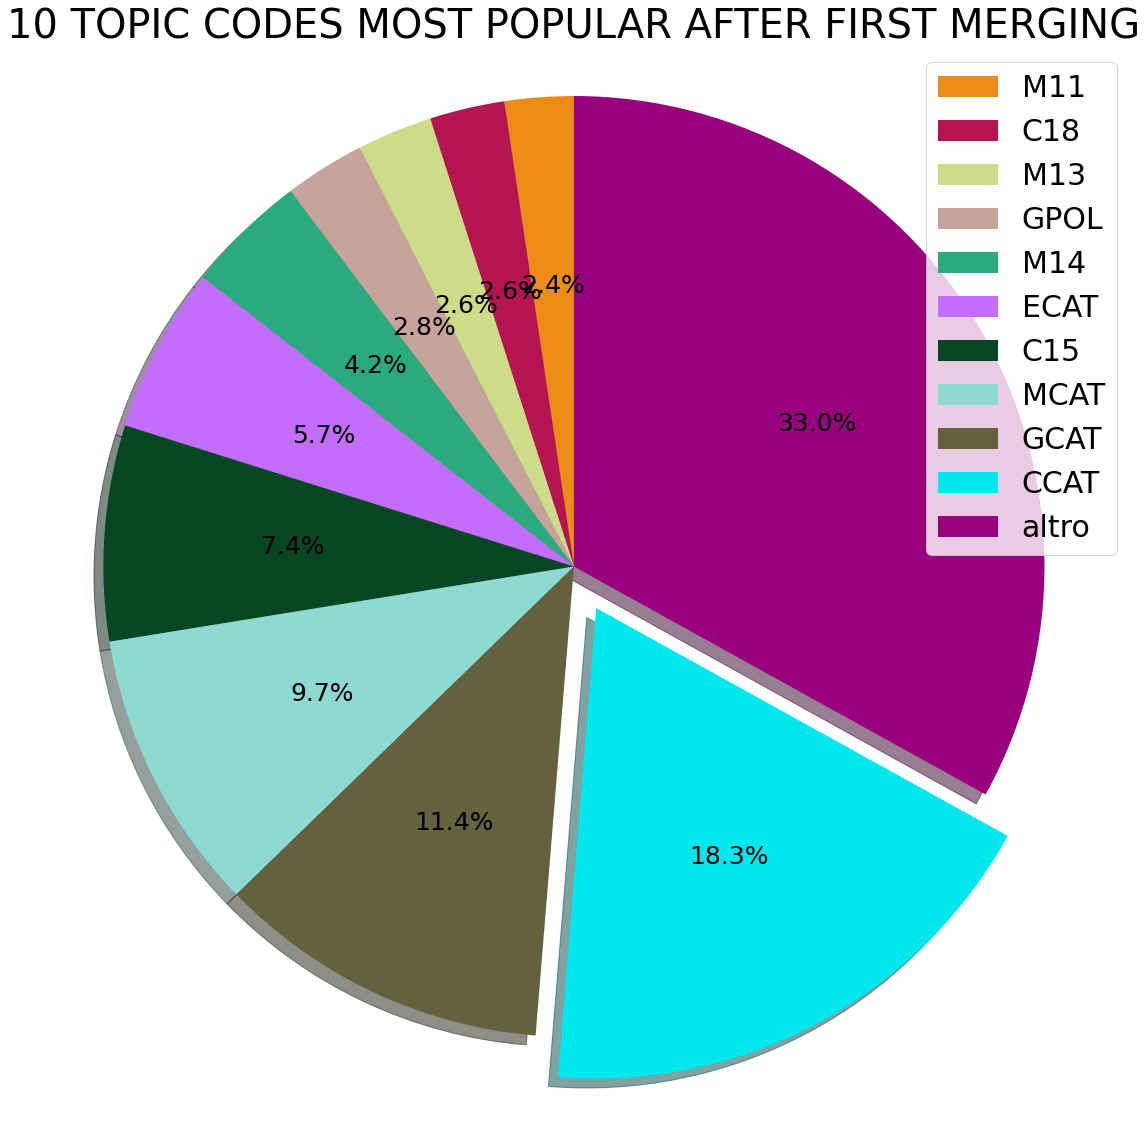

In [13]:
from random import randint
plotta_label_pie_from_dict(occorrenze,size=(20,20),valori_plottati=10,title_chart='10 TOPIC CODES MOST POPULAR AFTER FIRST MERGING')

In [14]:
y_label_occ,name_code_reduced=drop_label_non_presenti(y_topic_dict) #fai pure plot sotto

prima--> 78 ,dopo--> 59 ,eliminate 19 label con occorrenza = 0


In [15]:
name_code_reduced

dict_keys(['C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C21', 'C22', 'C23', 'C24', 'C31', 'C32', 'C33', 'C34', 'C41', 'C42', 'CCAT', 'E11', 'E12', 'E13', 'E14', 'E21', 'E31', 'E41', 'E51', 'E61', 'E71', 'ECAT', 'G15', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT', 'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL', 'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA', 'GWELF', 'M11', 'M12', 'M13', 'M14', 'MCAT'])

In [16]:
new_somma=[]
for ss in somma:
    if ss!=0:
        new_somma.append(ss)
print(len(new_somma))
with open(src+'topic_codes.csv', mode='r') as inp:
    reader = csv.reader(inp)
    dict_from_csv = {rows[0]:rows[1] for rows in reader}
del dict_from_csv['topic_code']
for i in range (len(new_somma)):
    print(list(name_code_reduced)[i],dict_from_csv[list(name_code_reduced)[i]],new_somma[i])

59
C11 STRATEGY/PLANS 24294
C12 LEGAL/JUDICIAL 11866
C13 REGULATION/POLICY 37322
C14 SHARE LISTINGS 7405
C15 PERFORMANCE 151524
C16 INSOLVENCY/LIQUIDITY 1915
C17 FUNDING/CAPITAL 42118
C18 OWNERSHIP CHANGES 52711
C21 PRODUCTION/SERVICES 25382
C22 NEW PRODUCTS/SERVICES 6096
C23 RESEARCH/DEVELOPMENT 2619
C24 CAPACITY/FACILITIES 32109
C31 MARKETS/MARKETING 40376
C32 ADVERTISING/PROMOTION 2075
C33 CONTRACTS/ORDERS 15312
C34 MONOPOLIES/COMPETITION 4829
C41 MANAGEMENT 11318
C42 LABOUR 11808
CCAT CORPORATE/INDUSTRIAL 373592
E11 ECONOMIC PERFORMANCE 8534
E12 MONETARY/ECONOMIC 26951
E13 INFLATION/PRICES 6574
E14 CONSUMER FINANCE 2168
E21 GOVERNMENT FINANCE 42958
E31 OUTPUT/CAPACITY 2406
E41 EMPLOYMENT/LABOUR 16960
E51 TRADE/RESERVES 21182
E61 HOUSING STARTS 384
E71 LEADING INDICATORS 4731
ECAT ECONOMICS 116507
G15 EUROPEAN COMMUNITY 20568
GCAT GOVERNMENT/SOCIAL 233967
GCRIM CRIME, LAW ENFORCEMENT 32100
GDEF DEFENCE 8807
GDIP INTERNATIONAL RELATIONS 37579
GDIS DISASTERS AND ACCIDENTS 8630
GENT AR

---
# Merging labels for similar topics
---

In [17]:
def aggrega_etichette_macro_gruppo(mydict):
    topics_aggregated_key_macro={}
    for cod in mydict.keys():
        radice=cod[:1]
        radice2=cod[1]
        if radice=='E':
            topics_aggregated_key_macro[cod]= 'ECONOMICS'
        elif radice=='C':
            topics_aggregated_key_macro[cod]= 'CORPORATE/INDUSTRIAL'
        elif radice=='M':
            topics_aggregated_key_macro[cod]= 'MARKETS'
        elif radice=='G':
            topics_aggregated_key_macro[cod]= 'GOVERNMENT/SOCIAL'
        else:
            topics_aggregated_key_macro[cod]= cod#mydict[cod]
        print('Aggrego',cod,' con desc:',mydict[cod],' nella radice:',topics_aggregated_key_macro[cod])
    return topics_aggregated_key_macro

In [18]:
if label_59==False:
    name_code_reduced_dict={x:topics_aggregated_key[x] for x in name_code_reduced}
    topics_aggregated_key_macro=aggrega_etichette_macro_gruppo(name_code_reduced_dict)
    print("L'array è di lunghezza:",len(np.unique(list(topics_aggregated_key_macro.values()))))

Aggrego C11  con desc: STRATEGY/PLANS  nella radice: CORPORATE/INDUSTRIAL
Aggrego C12  con desc: LEGAL/JUDICIAL  nella radice: CORPORATE/INDUSTRIAL
Aggrego C13  con desc: REGULATION/POLICY  nella radice: CORPORATE/INDUSTRIAL
Aggrego C14  con desc: SHARE LISTINGS  nella radice: CORPORATE/INDUSTRIAL
Aggrego C15  con desc: PERFORMANCE  nella radice: CORPORATE/INDUSTRIAL
Aggrego C16  con desc: INSOLVENCY/LIQUIDITY  nella radice: CORPORATE/INDUSTRIAL
Aggrego C17  con desc: FUNDING/CAPITAL  nella radice: CORPORATE/INDUSTRIAL
Aggrego C18  con desc: OWNERSHIP CHANGES  nella radice: CORPORATE/INDUSTRIAL
Aggrego C21  con desc: PRODUCTION/SERVICES  nella radice: CORPORATE/INDUSTRIAL
Aggrego C22  con desc: NEW PRODUCTS/SERVICES  nella radice: CORPORATE/INDUSTRIAL
Aggrego C23  con desc: RESEARCH/DEVELOPMENT  nella radice: CORPORATE/INDUSTRIAL
Aggrego C24  con desc: CAPACITY/FACILITIES  nella radice: CORPORATE/INDUSTRIAL
Aggrego C31  con desc: MARKETS/MARKETING  nella radice: CORPORATE/INDUSTRIAL
Ag

In [19]:
if label_59==False:
    clear_ds=aggrega_codes(clear_ds,topics_aggregated_key_macro)
    clear_ds.head(2)

elaborati 200000 record!
elaborati 400000 record!
elaborati 600000 record!
elaborati 800000 record!
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:07s


In [20]:
if label_59==False:
    y_label_code,y_topic_dict=Y_label_codes(clear_ds,np.unique(list(topics_aggregated_key_macro.values())))

analizzati 200000 record
analizzati 400000 record
analizzati 600000 record
analizzati 800000 record
analizzati 800802 record


valori con occ>0: 4


<Figure size 1800x1800 with 0 Axes>

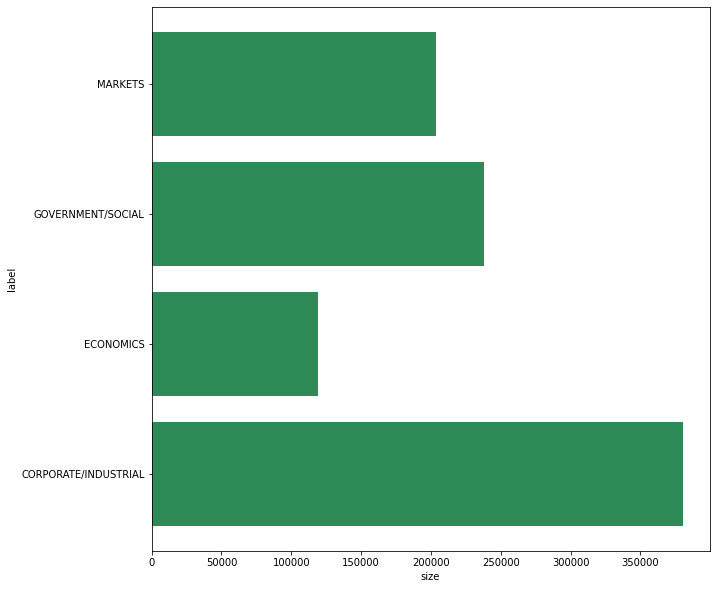

prima--> 4 ,dopo--> 4 ,eliminate 0 label con occorrenza = 0


In [21]:
if label_59==False:
    somma=vector_sum(y_topic_dict,y_label_code)
    codes_names=y_topic_dict.keys()
    occorrenze=count_occ(somma,codes_names)
    plot_topic_occ(somma, codes_names,size=(10,10))
    y_label_occ,name_code_reduced=drop_label_non_presenti(y_topic_dict) #fai pure plot sotto

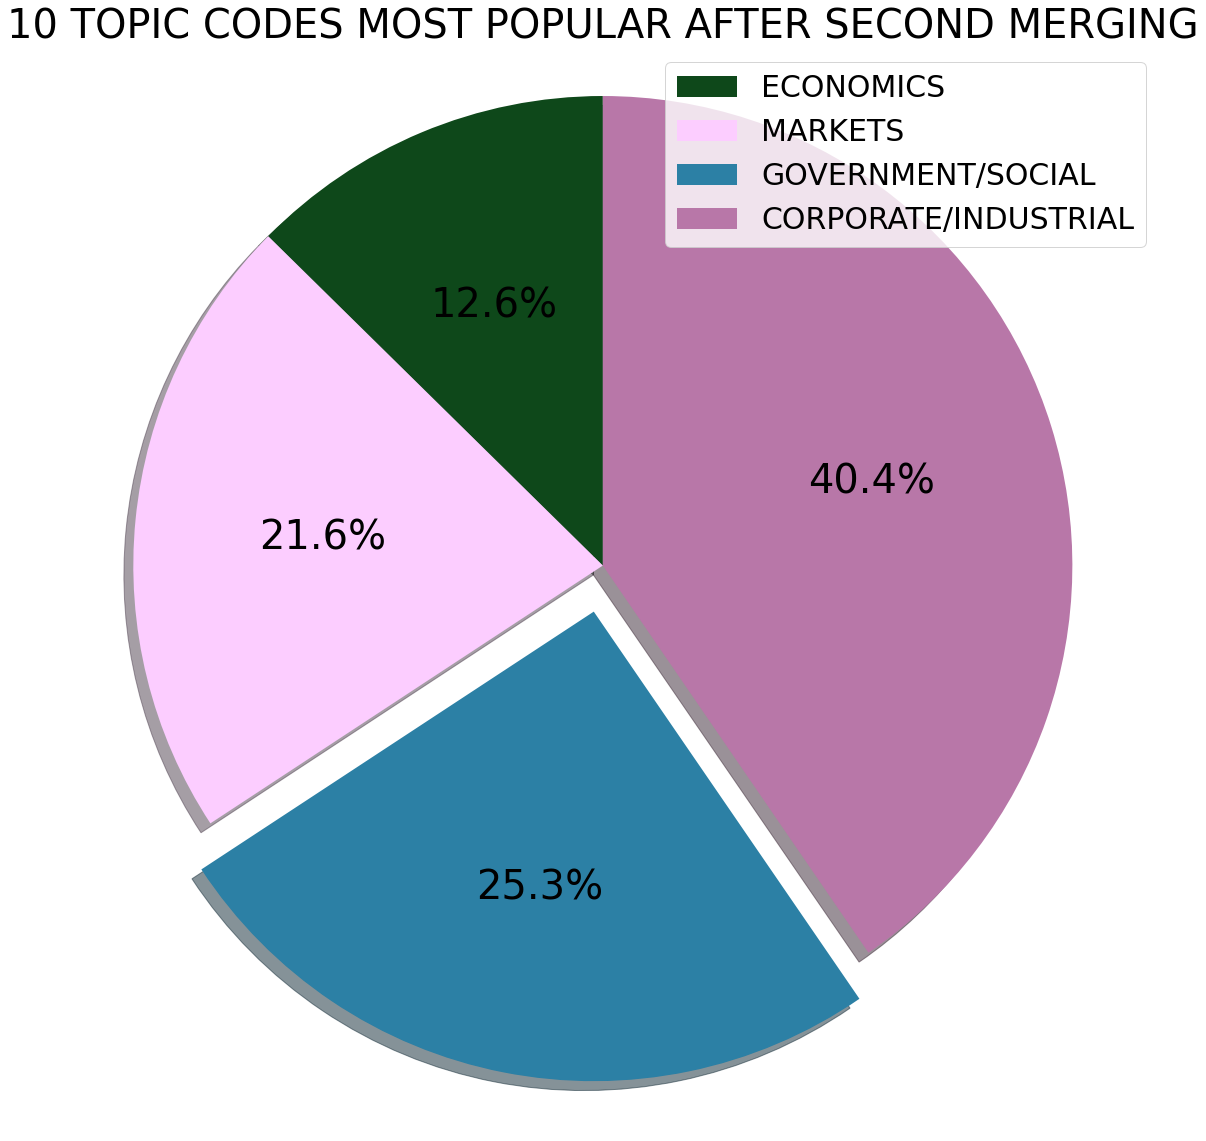

In [39]:
if label_59==False:
    plotta_label_pie_from_dict(occorrenze,size=(20,20),valori_plottati=4,title_chart='10 TOPIC CODES MOST POPULAR AFTER SECOND MERGING')

---
## Create vector labels to verify that there is no more than one identical code in the same single target
---

In [23]:
y_label_code,y_topic_dict=Y_label_codes(clear_ds,name_code_reduced)

analizzati 200000 record
analizzati 400000 record
analizzati 600000 record
analizzati 800000 record
analizzati 800802 record


In [24]:
#non vi sono più di un codice uguale nello stesso singolo target
# for ar in y_label_code:
#     for i in ar:
#         if i>1:
#             print(True)
conta_multilabel=0
for ar in y_label_code:
    conta=0
    for x in ar:
        if x==1:
            conta+=1
    if conta>1:
        conta_multilabel+=1
conta_multilabel

118872

---
# Data Preparation
---

In [25]:
def preprocessing(ds,print_val=200000,first=0,end=len(df)):
    New_Testo = []
    occ=0
    occ_print=print_val
    start_time = time.time()
    print('Analizzare i testi dalla riga:',first,', alla riga:',end)
    for ind in range (first,end):
        testo = str(ds[ind])
        #LOWER_CASE
        testo= testo.lower()
        #elimina citazione no perchè non ce ne sono
        
        # tokenization
        word_tokens = nltk.word_tokenize(testo);

        # Rimuovi punteggiatura
        word_tokens = list(filter(lambda token: token not in string.punctuation, word_tokens))

        # stopwords list
        stop_words = set(stopwords.words('english'))
        # stoppping
        filtered_sentence = [w for w in word_tokens if not w in stop_words]

        document = ' '.join(filtered_sentence)
        # sostituisci risultato:
        New_Testo.append(document)
        end_time = time.time()
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        if (occ%occ_print==0 and occ!=0) or (occ==(len(ds)-1)):
            print('analizzati',occ,'record',",tempo impiegato per trasformare",occ_print,"file: "+t,'size del vettore:',len(New_Testo)-1)
            start_time = time.time()
        occ+=1
    return New_Testo

In [26]:
def index_download():
#     indice_path='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/index_scan_text.txt'
    indice_path='/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/index_scan_text.txt'
    ind=0
    if not Path(indice_path).exists():
        f= open(indice_path, "w")
        f.write(str(0))
        f.close()    
    f=open(indice_path,"r")
    ind=int(f.read())
    f.close()
    return int(ind)

def carica_text(indice):
    if not Path(src+'outputfile_text_processed.csv').exists():
        print('Creato file di checkpoint per il nostro array dei testi processati')
        with open(src+'outputfile_text_processed.csv', 'w') as temp:
            primo=preprocessing(testi,10,indice,indice+1)
            pp=pandas.DataFrame(primo, columns = ['text'])
            pp.to_csv(temp, index=False)
            indice+=1
    with open (src+'outputfile_text_processed.csv', 'r') as temp:
        processed_text = pandas.read_csv(temp)
    return processed_text,indice

def salva_text(indice,testi):
    #     indice_path='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/index_scan_text.txt'
    indice_path='/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/index_scan_text.txt'
    with open(indice_path, 'w') as temp:
        temp.truncate(0)
        temp.write(str(indice))
        temp.close()

    with open(src+'outputfile_text_processed.csv', 'w') as temp:
        testi.to_csv(temp, index=False)
    return testi

testi=clear_ds['text'].copy().tolist()

print('I record in totale sono:',len(testi))
indice=index_download()
print("L'ultimo checkpoit è stato al record:",indice)

text_loaded,indice=carica_text(indice)

stampa_ogni=200000
end_ds=indice+(stampa_ogni*5)

if indice==1:
    end_ds-=1
if end_ds>len(testi):
    end_ds=len(testi)
if indice!=len(testi):
    new_text_processed=pandas.DataFrame( preprocessing(testi,stampa_ogni,indice,end_ds),columns = ['text'])
    processed_text=pandas.DataFrame.append(text_loaded,new_text_processed)
    processed_text_final=salva_text(end_ds,processed_text)

I record in totale sono: 800803
L'ultimo checkpoit è stato al record: 800803


In [27]:
processed_text_final=text_loaded.copy()
processed_text_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800803 entries, 0 to 800802
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    800803 non-null  object
dtypes: object(1)
memory usage: 6.1+ MB


In [28]:
len(processed_text_final)==len(y_label_code)

True

In [29]:
arr_label = np.array(y_label_code)
if label_59==True:
    np.savetxt(src+'numeric_label_topic_59.txt', arr_label, fmt='%d') #integer format
else:
    np.savetxt(src+'numeric_label_topic.txt', arr_label, fmt='%d') #integer format

In [30]:
if label_59==True:
    arr_label = np.loadtxt(src+'numeric_label_topic_59.txt', dtype=int)
else:
    arr_label = np.loadtxt(src+'numeric_label_topic.txt', dtype=int)
print(len(arr_label))
arr_label

800803


array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 1]])

---
# Preparation final Dataset
---

In [31]:
if label_59==False:
    class_names=list(y_topic_dict.keys())
    class_names_dict={n:n for n in class_names}
else:
    with open(src+'topic_codes.csv', mode='r') as inp:
        reader = csv.reader(inp)
        dict_from_csv = {rows[0]:rows[1] for rows in reader}
    del dict_from_csv['topic_code']
    class_names=list(y_topic_dict.keys())
    class_names_dict={n:dict_from_csv[n] for n in class_names}
class_names_dict

{'CORPORATE/INDUSTRIAL': 'CORPORATE/INDUSTRIAL',
 'ECONOMICS': 'ECONOMICS',
 'GOVERNMENT/SOCIAL': 'GOVERNMENT/SOCIAL',
 'MARKETS': 'MARKETS'}

In [32]:
if label_59==True:
    with open("myDictionary_labels_59.npy", "wb") as tf:
        np.save(tf,class_names_dict)
else:
    with open("myDictionary_labels.npy", "wb") as tf:
        np.save(tf,class_names_dict)

In [33]:
Data_Set=pandas.DataFrame({'text':list(processed_text_final['text']),'target':y_label_code})
Data_Set

,text,target
0,uk share market unlikely make much headway nex...,"[0, 0, 0, 1]"
1,cbot soft red winter wheat futures closed most...,"[0, 0, 0, 1]"
2,beijing friday condemned u.s. sanctions impose...,"[0, 1, 1, 0]"
3,year march 31 1998 billions yen unless specifi...,"[1, 0, 0, 0]"
4,pregnant ira bomb suspect released bail friday...,"[0, 0, 1, 0]"
...,...,...
800798,slovenian development fund state 's restructur...,"[1, 0, 0, 0]"
800799,slow development widely variable corn crop con...,"[1, 0, 0, 0]"
800800,nbc series quot er quot emmy award sunday best...,"[0, 0, 1, 0]"
800801,sun-diamond growers california went court mond...,"[1, 0, 1, 0]"


In [34]:
# Data_Set_code=pandas.DataFrame({'text':list(processed_text_final['text']),'target':y_label_code,'code':clear_ds['topic_codes']})
# Data_Set_code
# with open(src+'GCP_TEXT_AND_LABEL_PROCESSED.csv', 'w') as temp:
#     Data_Set_code.to_csv(temp, index=False)

In [35]:
def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.histplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Text count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

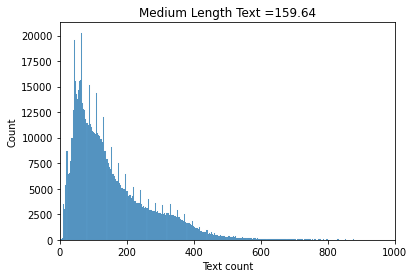

In [36]:
plot_token_occ(Data_Set['text'].tolist(),0,1000,'','Medium Length Text')

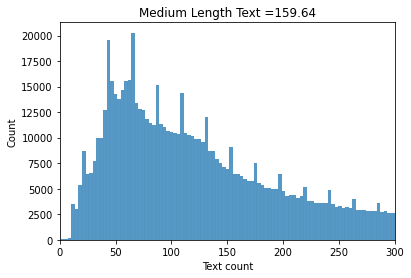

In [37]:
plot_token_occ(Data_Set['text'].tolist(),0,300,'','Medium Length Text')